# CIVL 555 - Final Project Discussion

| Name | Student Number | Date |
|---|---|---|
| Dan Kovacek | 35402767 | 17 April 2020 |

### Overview
The focus of this presentation is the paper *Sensor Placement in Water Networks Using a Population-Based Ant Colony Optimization Algorithm* (Diwold, Ruhnke, and Middendorf 2010).  The format of this presentation is an interactive Python notebook (using Jupyter), and the aim is to introduce the mechanics of a basic Ant Colony Optimization (ACO) algorithm through implementation of an ACO to the same type of optimal sensor placement problem (SPP) approached in the study.

### Example Case
Like many other studies, (Diwold, Ruhnke, and Middendorf 2010) uses two municipal water networks (MWN) provided by the United States Envirionmental Protection Agency (USEPA) as benchmark examples to demonstrate the performance of the ACO algorithm developed in their study.  Both MWNs are freely available online, and the one selected for demonstration herein represents the water distribution network of Richmond, Virginia.  The MWN features 872 nodes and 957 connecting pipes.

### Open Source Frameworks

The open-source Python package [WNTR (Water Network Tool for Resilience)](https://wntr.readthedocs.io/en/latest/), developed by Sandia National Laboratories, is used here to demonstrate the setup and execution of a hydraulic model that implements an ACO algorithm similar to that presented in (Diwold, Ruhnke, and Middendorf 2010).

The WNTR package is extremely powerful and is equipped for analyzing many problems related to MWNs, including hydraulic modelling, and optimal sensor placement for such problems as leak localization and contamination detection.

In [45]:
# python package imports
import wntr
import chama

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
# import the network graph representation of the MWN 
# (the 'skeletion' is a smaller network for code development)
filename = 'Richmond_skeleton.txt'
# filename = 'Richmond.txt'

# wn = wntr.network.WaterNetworkModel(filename_skel)
wn = wntr.network.WaterNetworkModel(filename)

(<matplotlib.collections.PathCollection at 0x7fb03202df98>,
 <matplotlib.collections.LineCollection at 0x7fb031fb12e8>)

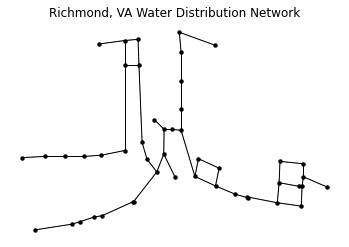

In [51]:
# visualize the network
# fig, ax = plt.subplots(1, 1, figsize=(4,4))
wntr.graphics.plot_network(wn, title="Richmond, VA Water Distribution Network")

## Ant Colony Optimiztion (ACO)

The ACO is an algorithm that mimics the foraging behaviour of ant colonies in nature.  Individual ants can search the decision space near the current set of optimal solutions to make refinements on the existing solution (referred to as local heuristics), or they can search farther away to escape the local optima and find a better solution (pheromone information).  

## (Population Based) Ant Colony Optimization (PACO)

The ACO is limited to single-objective optimization problems.  An approach to address multi-objective optimization problems was proposed by (Guntsch et al. 2003) wherein instead of the set of ants only remembering one best solution each generation, a 'population' of best solutions describing the non-dominated Pareto set is constructed.  The pheromone information gets distributed to this population, and the population is updated when a newly encountered solution is found to dominate a solution in the population.  The newly dominated solution is then removed from having influence on the search.

## Set up the Simulation Parameters

Set up the parameters used in the simulation.  Comments will indicate the parameter settings that were used in (Diwold, Ruhnke, and Middendorf 2010).

In [49]:
# number of flow patterns 
n_patterns = 10 # 55
# flow scenario cycle time (hours)
t_cycle = 24 # 24
# number of sensors
n_sensors = 3 # 5
# number of sets of contamination events
n_event_sets = 1 # 2
# number of contamination events
n_cont_events = 500 # 2000

# Define the Objective Function(s)

In the case of (Diwold, Ruhnke, and Middendorf 2010), the objectives are to minimize the detection time of contaminations ($Z_1$), defined as the elapsed time between the start of the contamination event and the detection by a sensor, assuming ideal sensor operation, and to minimize the rate of non-detection ($Z_2$), defined as the number of contamination scenarios for which the given network cannot detect the contamination event.  

$$Z_1(S, C) = \frac{1}{D_S^C} \sum_{C\in D_S^C}d(C, S)$$
$$Z_2(S, C) = 1 - \frac{|D_S^C|}{|C|}$$

Note that the two goals are in opposition, so movement in the decision space is necessarily a tradeoff of better performance of one criterion for worse performance of another criterion.

## Set up the contamination hydraulic model

To be more computationally efficient, the contamination hydraulic model should be initialized before the sensor placement problem is run.  

Simulations can are run for different scenarios of contamination *at each junction*, thereby covering the entire decision space.  These contaminant tracer scenarios are then saved to disk and recalled later for the sensor placement problem.

In [54]:
# Run trace simulations (one from each junction) and extract data needed for 
# sensor placement optimization. You can run this step once, save the data to a 
# file, and reload the file for sensor placement

# note this only has to be run ONCE
# before the sensor placement problem is executed

scenario_names = wn.junction_name_list
sim = wntr.sim.EpanetSimulator(wn)
sim.run_sim(save_hyd = True)
wn.options.quality.mode = 'TRACE'
signal = pd.DataFrame()
for inj_node in scenario_names:
    wn.options.quality.trace_node = inj_node
    sim_results = sim.run_sim(use_hyd = True)
    trace = sim_results.node['quality']
    trace = trace.stack()
    trace = trace.reset_index()
    trace.columns = ['T', 'Node', inj_node]
    signal = signal.combine_first(trace)
signal.to_csv('test_signal.csv')

## Define the set of feasible sensor locations

Feasible sensor locations are determined by the physical location, sample times, and the detection threshold.

Then, for each contamination scenario at each node, extract the minimum detection time.


In [62]:
sensor_names = wn.junction_name_list
sample_times = np.arange(0, wn.options.time.duration, wn.options.time.hydraulic_timestep)
threshold = 20
sensors = {}
for location in sensor_names:
    position = chama.sensors.Stationary(location)
    detector = chama.sensors.Point(threshold, sample_times)
    stationary_pt_sensor = chama.sensors.Sensor(position, detector)
    sensors[location] = stationary_pt_sensor
    
    
# Extract minimum detection time for each scenario-sensor pair
det_times = chama.impact.extract_detection_times(signal, sensors)
det_time_stats = chama.impact.detection_time_stats(det_times)
min_det_time = det_time_stats[['Scenario','Sensor','Min']].copy()
min_det_time.rename(columns = {'Min':'Impact'}, inplace = True)

## Run the Sensor Placement Optimization Algorithm

In [63]:
# Run sensor placement optimization to minimize detection time using 0 to 5 sensors
#   The impact for undetected scenarios is set at 1.5x the max sample time
#   Sensor cost is defined uniformly using a value of 1.  This means that
#   sensor_budget is equal to the number of sensors to place
impactform = chama.optimize.ImpactFormulation()
scenario_characteristics = pd.DataFrame({'Scenario': scenario_names,
                                         'Undetected Impact': sample_times.max()*1.5})
sensor_characteristics = pd.DataFrame({'Sensor': sensor_names,'Cost': 1})
sensor_budget = [0,1,2,3,4,5]
results = {}
for n in sensor_budget:
    impactform = chama.optimize.ImpactFormulation()
    coveragform = chama.optimize.CoverageFormulation()
    results[n] = impactform.solve(min_det_time, sensor_characteristics, 
                                  scenario_characteristics, n)


## Present Results of the Optimization Problem

Text(0, 0.5, 'Expected time to detection (hr)')

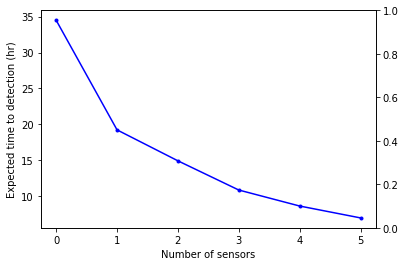

In [64]:
# Plot objective for each sensor placement
objective_values =[results[n]['Objective']/3600 for n in sensor_budget]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.plot(sensor_budget, objective_values, 'b', marker='.')
ax1.set_xlabel('Number of sensors')
ax1.set_ylabel('Expected time to detection (hr)')

## Plot the Approximate Optimal Solution

Plot both the sensor placement layout representing the approximate solution, as well as a 'heat map' of the detection times for all nodes in the system.

(<matplotlib.collections.PathCollection at 0x7fb036bcf5f8>,
 <matplotlib.collections.LineCollection at 0x7fb036bcf9b0>)

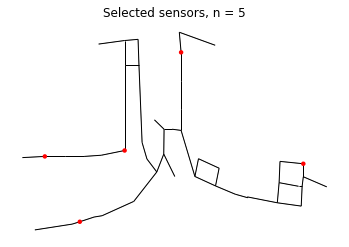

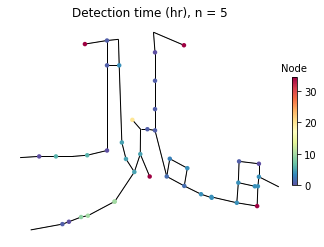

In [66]:
# Plot selected sensors, when using 3 sensors
n = 5
selected_sensors = results[n]['Sensors']
wntr.graphics.plot_network(wn, node_attribute=selected_sensors, 
                           title='Selected sensors, n = {}'.format(n))

# Plot detection time for each scenario, when using 3 sensors
assessment = results[n]['Assessment']
assessment.set_index('Scenario', inplace=True)
wntr.graphics.plot_network(wn, node_attribute=assessment['Impact']/3600, 
                           title='Detection time (hr), n = {}'.format(n))

## Probability of Sensor Placement



An ant creates a solution iteratively, accounting for the sensors it has already placed.



In [37]:
def determine_placement_probability(tau, eta, alpha, beta, n_sensors, n_nodes):
    """
    Create the probability matrix of node selection, based on Equation 6 in 
    (Diwold, Ruhnke, and Middendorf 2010).
    """    
    prob_array = np.zeros((n_nodes, n_sensors))
    for k in range(n_sensors):
        eta_array = np.power(eta[:, k], [beta for b in eta[:, k]])
        tau_array = np.power(tau, [alpha for a in tau])
        sum_tau_eta = np.dot(eta_array, tau_array).sum()
        for i in range(n_nodes):
            prob_array[k, i] = ((tau[i]**alpha) * (eta[k, i]**beta)) / (sum_tau_eta)
    return prob_array
            
    

In [22]:
tau1 = [1, 2, 1, 2.3, 1.3, 0.5]
eta = [(0.5, 1), (1, 1), (0.4, 0.3), (0.3, 0.4), (0.9, 1.1)]
alp = 0.3
bet = 0.9


In [35]:
tau_arr = np.power(tau1, [alp for a in tau1])
# eta_arr = np.power(eta)
eta_mat = np.matrix(eta)
print(eta_mat[:,0])

[[0.5]
 [1. ]
 [0.4]
 [0.3]
 [0.9]]


In [ ]:
wn.options.quality.mode = 'CHEMICAL'

In [6]:
# Simulate hydraulics
sim = wntr.sim.EpanetSimulator(wn)

In [7]:
results = sim.run_sim()

# References

* Klise, K.A., Murray, R., Haxton, T. (2018). An overview of the Water Network Tool for Resilience (WNTR), In Proceedings of the 1st International WDSA/CCWI Joint Conference, Kingston, Ontario, Canada, July 23-25, 075, 8p.

* Klise, K.A., Bynum, M., Moriarty, D., Murray, R. (2017). A software framework for assessing the resilience of drinking water systems to disasters with an example earthquake case study, Environmental Modelling and Software, 95, 420-431, doi: 10.1016/j.envsoft.2017.06.022

* Klise, K.A., Hart, D.B., Moriarty, D., Bynum, M., Murray, R., Burkhardt, J., Haxton, T. (2017). Water Network Tool for Resilience (WNTR) User Manual, U.S. Environmental Protection Agency Technical Report, EPA/600/R-17/264, 47p.